In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
fourier = pd.read_csv(
    "../data/results/best_steel_fourier_freq_model-raw_steel_predictions.csv"
)
steel = pd.read_csv("../data/results/best_steel_model-raw_steel_predictions.csv")
general = pd.read_csv("../data/results/best_general_model-raw_steel_predictions.csv")
exact = pd.read_csv(
    "../data/results/exact_method/exact_method-raw_steel_predictions.csv"
)

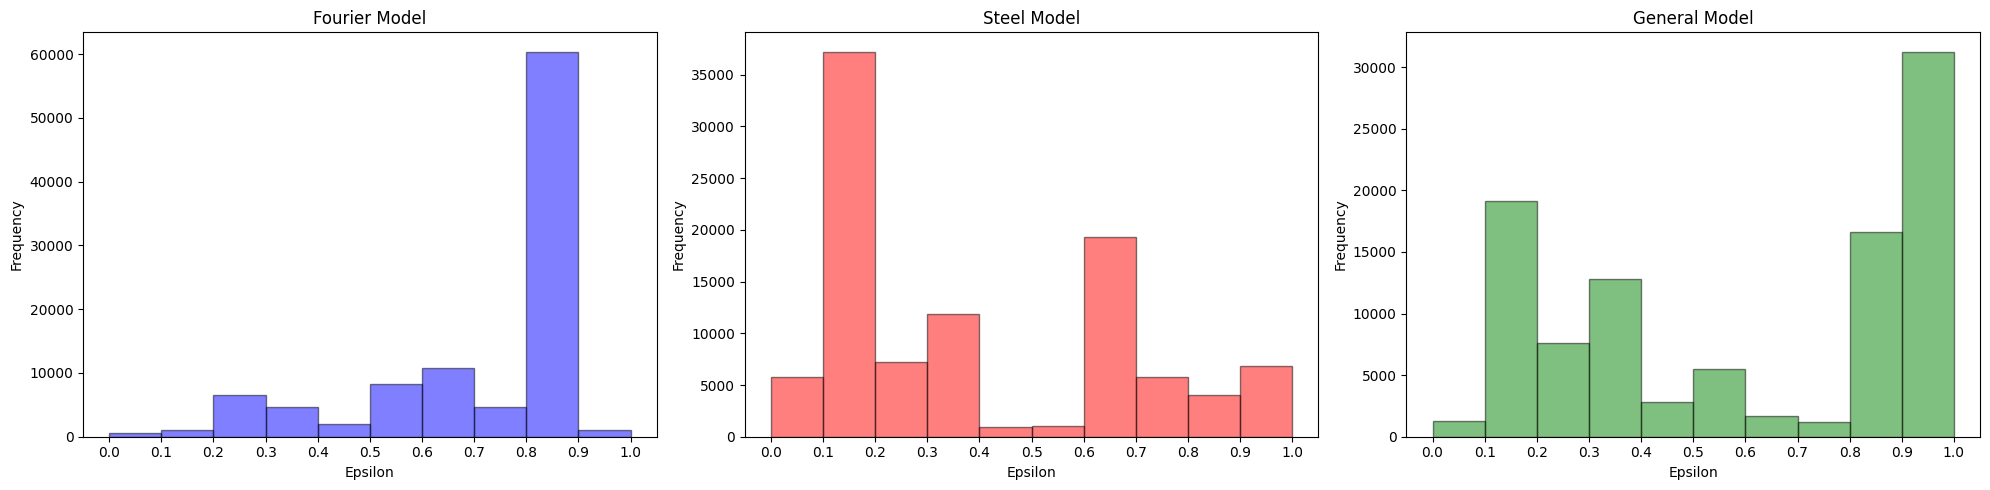

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(
    fourier["epsilon"],
    bins=10,
    range=(0, 1),
    color="blue",
    alpha=0.5,
    edgecolor="black",
)
ax[0].set_title("Fourier Model")
ax[0].set_xlabel("Epsilon")
ax[0].set_ylabel("Frequency")
ax[0].set_xticks(np.arange(0, 1.1, 0.1))

ax[1].hist(
    steel["epsilon"], bins=10, range=(0, 1), color="red", alpha=0.5, edgecolor="black"
)
ax[1].set_title("Steel Model")
ax[1].set_xlabel("Epsilon")
ax[1].set_ylabel("Frequency")
ax[1].set_xticks(np.arange(0, 1.1, 0.1))

ax[2].hist(
    general["epsilon"],
    bins=10,
    range=(0, 1),
    color="green",
    alpha=0.5,
    edgecolor="black",
)
ax[2].set_title("General Model")
ax[2].set_xlabel("Epsilon")
ax[2].set_ylabel("Frequency")
ax[2].set_xticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()
plt.show()

# Captum comparison: Good vs Bad predictions #

In [22]:
# merge exact and fourier dataframes
df = pd.DataFrame(
    {
        "filename": exact["filename"],
        "exact": exact["epsilon"],
        "fourier": fourier["epsilon"],
    }
)

In [23]:
def cyclic_MAE_test(output, target):
    return min(
        abs(output - target), min(abs(output - target + 1), abs(output - target - 1))
    )

In [26]:
e = df["exact"].to_numpy()
f = df["fourier"].to_numpy()

diff = np.array([cyclic_MAE_test(f[i], e[i]) for i in range(len(e))])
df["loss"] = diff

In [28]:
loss = df["loss"].to_numpy()

In [29]:
# take the 5 largest errors
bad_preds = np.argsort(loss)[-5:]
# take the 5 smallest errors
good_preds = np.argsort(loss)[:5]

In [33]:
model = models.resnet18(pretrained=True)

classifier = nn.Sequential(
    nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.3), nn.ReLU(), nn.Linear(512, 1000)
)

model.fc = classifier
# load the model from state_dict
model.load_state_dict(torch.load("../models/best_steel_fourier_model.pth"))
model.cuda()
model.eval()

c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

In [35]:
class ImageDataset(Dataset):
    def __init__(self, path: str, parameters: pd.DataFrame, transform=None) -> None:
        self.image_paths = np.array(
            [path + filename for filename in parameters["filename"].to_numpy()]
        )
        self.labels = parameters["epsilon"].to_numpy()
        self.transform = transform

    def __getitem__(self, inx):
        image_path = self.image_paths[inx]
        label_float_epsilon = self.labels[inx]
        target = np.zeros(shape=(1000,))
        target[int(label_float_epsilon * 1000)] = 1
        image = Image.open(image_path)
        image = np.array(image)
        # repeat grayscale value three times for all RGB channels
        image = np.repeat(image[..., np.newaxis], 3, -1)
        if self.transform:
            image = self.transform(image)
        return image, torch.from_numpy(target)

    def __len__(self):
        return len(self.image_paths)


transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)


def prepare_image_for_prediction(image_path: str) -> torch.Tensor:
    df = pd.DataFrame({"filename": [image_path.split("/")[-1]], "epsilon": [0]})
    dataset = ImageDataset(
        path=image_path.rsplit("/", 1)[0] + "/", parameters=df, transform=transform
    )
    image_tensor, _ = dataset[0]
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.cuda()
    return image_tensor


def prediction_to_real_value(prediction: torch.Tensor) -> float:
    """
    Convert the model's prediction tensor to a real value in the range [0.0, 1.0].

    Parameters:
    - prediction (torch.Tensor): The prediction tensor, typically of shape (batch_size, 1000).

    Returns:
    - float: The real value in the range [0.0, 1.0].
    """
    max_index = torch.argmax(prediction, dim=1).item()
    real_value = max_index / 1000.0
    return real_value

In [37]:
integrated_gradients = IntegratedGradients(model)
noise_tunnel = NoiseTunnel(integrated_gradients)

from matplotlib.colors import LinearSegmentedColormap

default_cmap = LinearSegmentedColormap.from_list(
    "custom blue", [(0, "#ffffff"), (0.25, "#000000"), (1, "#000000")], N=256
)

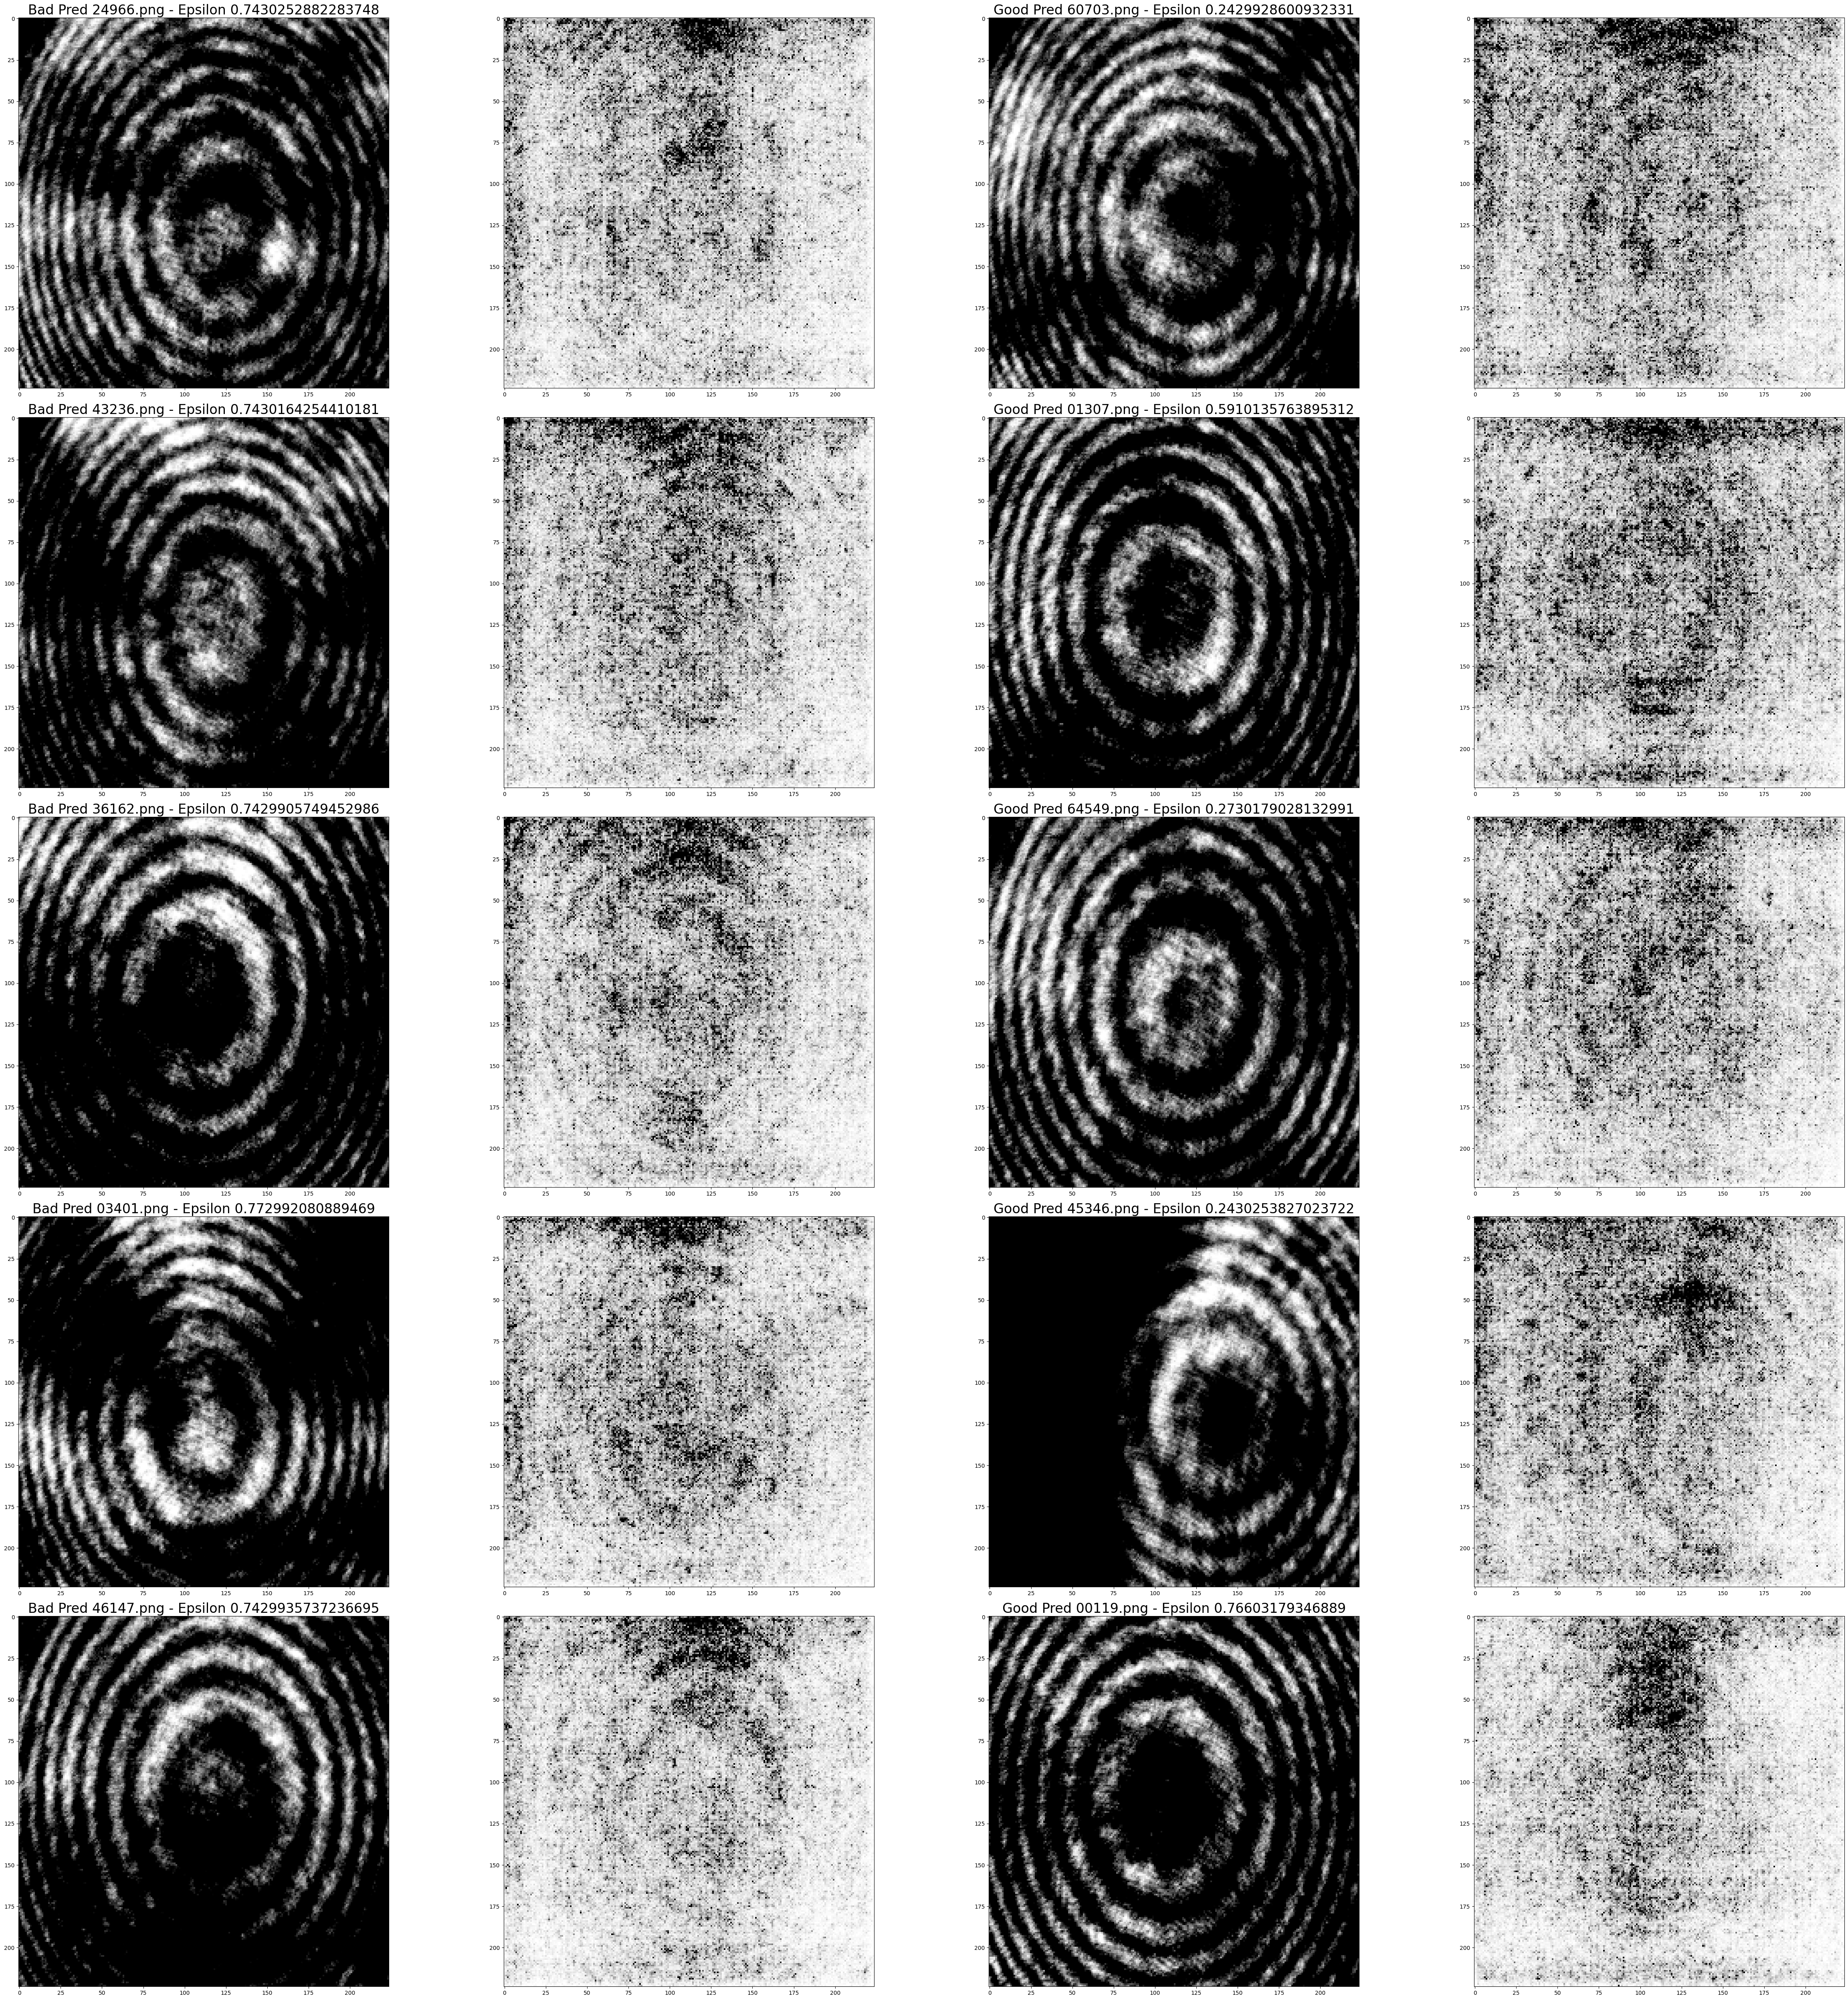

In [51]:
fig, ax = plt.subplots(5, 4, figsize=(50, 50))

for i, idx in enumerate(bad_preds):
    image = prepare_image_for_prediction(
        "../data/raw/steel/1channel/" + df["filename"][idx]
    )
    attribution = noise_tunnel.attribute(
        image,
        nt_samples=10,
        nt_type="smoothgrad_sq",
        target=torch.argmax(model(image), 1),
    )
    image_np = image.squeeze().cpu().numpy().transpose(1, 2, 0)
    _fig, _ax = viz.visualize_image_attr_multiple(
        np.transpose(attribution.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        image_np,
        ["original_image", "heat_map"],
        ["all", "positive"],
        cmap=default_cmap,
        show_colorbar=True,
        use_pyplot=False,
    )
    ax[i, 0].imshow(_ax[0].images[0].get_array(), cmap=default_cmap)
    ax[i, 0].set_title(
        f"Bad Pred {df['filename'][idx]} - Epsilon {df['exact'][idx]}", fontsize=24
    )
    ax[i, 1].imshow(_ax[1].images[0].get_array(), cmap=default_cmap)


for i, idx in enumerate(good_preds):
    image = prepare_image_for_prediction(
        "../data/raw/steel/1channel/" + df["filename"][idx]
    )
    attribution = noise_tunnel.attribute(
        image,
        nt_samples=10,
        nt_type="smoothgrad_sq",
        target=torch.argmax(model(image), 1),
    )
    image_np = image.squeeze().cpu().numpy().transpose(1, 2, 0)
    _fig, _ax = viz.visualize_image_attr_multiple(
        np.transpose(attribution.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        image_np,
        ["original_image", "heat_map"],
        ["all", "positive"],
        cmap=default_cmap,
        show_colorbar=True,
        use_pyplot=False,
    )
    ax[i, 2].imshow(_ax[0].images[0].get_array(), cmap=default_cmap)
    ax[i, 2].set_title(
        f"Good Pred {df['filename'][idx]} - Epsilon {df['exact'][idx]}", fontsize=24
    )
    ax[i, 3].imshow(_ax[1].images[0].get_array(), cmap=default_cmap)


plt.tight_layout()
plt.show()

In [46]:
_ax[0].images[0].get_array()

masked_array(
  data=[[[  0,   0,   0],
         [ 27,  27,  27],
         [173, 173, 173],
         ...,
         [123, 123, 123],
         [ 49,  49,  49],
         [ 85,  85,  85]],

        [[ 21,  21,  21],
         [ 43,  43,  43],
         [151, 151, 151],
         ...,
         [ 73,  73,  73],
         [ 77,  77,  77],
         [ 79,  79,  79]],

        [[ 15,  15,  15],
         [ 69,  69,  69],
         [181, 181, 181],
         ...,
         [ 25,  25,  25],
         [ 69,  69,  69],
         [ 67,  67,  67]],

        ...,

        [[161, 161, 161],
         [ 41,  41,  41],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[195, 195, 195],
         [103, 103, 103],
         [ 59,  59,  59],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[223, 223, 223],
         [143, 143, 143],
         [ 75,  75,  75],
         ...,
         [  0,   0, 

# Current noise phase distribution #

In [3]:
import os

# Directory to scan for PNG files
directory_path = "../data/fourier_noise/steel/"

# List to store PNG filenames
png_filenames = []

# Scan the directory for PNG files
for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file.endswith(".png"):
            png_filenames.append(file)

len(png_filenames)

500

In [33]:
indices = [int(png_filenames[i][-9:][:-4]) for i in range(len(png_filenames))]

In [35]:
# take epsilons from exact dataframe with indices
epsilons = exact["epsilon"].to_numpy()
epsilons = epsilons[indices]

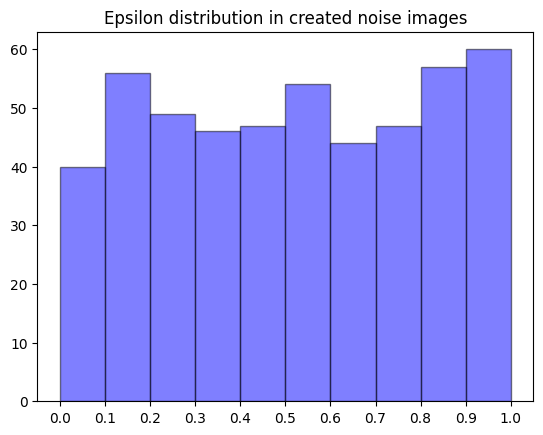

In [42]:
plt.hist(epsilons, bins=10, range=(0, 1), color="blue", alpha=0.5, edgecolor="black")
plt.title("Epsilon distribution in created noise images")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()